## import fgm tables


In [ ]:
!pip install gdown
!mkdir ./data
import gdown

def data_import():
  ids = {
      "tables_of_fgm.h5":"1XHPF7hUqT-zp__qkGwHg8noRazRnPqb0"
  }

  url = 'https://drive.google.com/uc?id='

  for title, g_id in ids.items(): 
    try:
      output_file = open("/content/data/" + title, 'wb')
      gdown.download(url + g_id, output_file, quiet=False)
    except IOError as e:
      print(e)
    finally:
      output_file.close()
      
data_import()

Downloading...
From: https://drive.google.com/uc?id=1XHPF7hUqT-zp__qkGwHg8noRazRnPqb0
To: <_io.BufferedWriter name='/content/tables_of_fgm.h5'>
982MB [00:06, 153MB/s]


# Function libaries

## ResBlock

```res_block``` is the backbone of the resnet structure. The resblock has multi branch, bottle neck layer and skip connection build in.  This modularized design has made create deep neural network easy. 

In [1]:
import tensorflow as tf
import keras
from keras.layers import Dense, Activation, Input, BatchNormalization, Dropout, concatenate
from keras import layers

def res_branch(bi, conv_name_base, bn_name_base, scale, input_tensor, n_neuron, stage, block,dp1, bn=False):
    x_1 = Dense(scale * n_neuron, name=conv_name_base + '2a_'+str(bi))(input_tensor)
    if bn:
        x_1 = BatchNormalization(axis=-1, name=bn_name_base + '2a_'+str(bi))(x_1)
    x_1 = Activation('relu')(x_1)
    if dp1>0:
      x_1 = Dropout(dp1)(x_1)
    return x_1

def res_block(input_tensor,scale, n_neuron, stage, block, bn=False,branches=0):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

#     scale = 2
    x = Dense(scale * n_neuron, name=conv_name_base + '2a')(input_tensor)
    if bn:
        x = BatchNormalization(axis=-1, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)
    dp1=0.
    if dp1 >0:
        x = Dropout(dp1)(x)
    
    branch_list=[x]
    for i in range(branches-1):
        branch_list.append(res_branch(i,conv_name_base, bn_name_base, scale,input_tensor,n_neuron,stage,block,dp1,bn))
    if branches-1 > 0:
        x = Dense(n_neuron, name=conv_name_base + '2b')(concatenate(branch_list,axis=-1))
#         x = Dense(n_neuron, name=conv_name_base + '2b')(layers.add(branch_list))
    else:
        x = Dense(n_neuron, name=conv_name_base + '2b')(x)
    
    if bn:
        x = BatchNormalization(axis=-1, name=bn_name_base + '2b')(x)
    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    if dp1 >0:
        x = Dropout(dp1)(x)

    return x

Using TensorFlow backend.


## data_reader
The ```read_h5_data``` function read the table from the hdf5 file. 

In the FGM case we chose not to scale the input features, since they all falls between 0 and 1. There are a great variety in the output features. In the reaction region close to stoichiometry the gradient in the output properties are great. A good example is the source term for progress variable, which rises from 0 to 1e5. So the output features are first transformed to logrithmic scale and then rearranged between  0 and 1. The outputs are normalised by its variance. This way the output value will be large where the gradient is great. So during training more focus would be put. The same 'focus design' has been put on the loss function selection as well. mse is selected over mae for that the squared error put more weights on the data samples that shows great changes. 

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler


class data_scaler(object):
    def __init__(self):
        self.norm = None
        self.norm_1 = None
        self.std = None
        self.case = None
        self.scale = 1
        self.bias = 1e-20
#         self.bias = 1


        self.switcher = {
            'min_std': 'min_std',
            'std2': 'std2',
            'std_min':'std_min',
            'min': 'min',
            'no':'no',
            'log': 'log',
            'log_min':'log_min',
            'log2': 'log2',
            'tan': 'tan'
        }

    def fit_transform(self, input_data, case):
        self.case = case
        if self.switcher.get(self.case) == 'min_std':
            self.norm = MinMaxScaler()
            self.std = StandardScaler()
            out = self.norm.fit_transform(input_data)
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'std2':
            self.std = StandardScaler()
            out = self.std.fit_transform(input_data)

        if self.switcher.get(self.case) == 'std_min':
            self.norm = MinMaxScaler()
            self.std = StandardScaler()
            out = self.std.fit_transform(input_data)
            out = self.norm.fit_transform(out)

        if self.switcher.get(self.case) == 'min':
            self.norm = MinMaxScaler()
            out = self.norm.fit_transform(input_data)

        if self.switcher.get(self.case) == 'no':
            self.norm = MinMaxScaler()
            self.std = StandardScaler()
            out = input_data

        if self.switcher.get(self.case) == 'log':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            self.std = StandardScaler()
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'log_min':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            self.norm = MinMaxScaler()
            out = self.norm.fit_transform(out)

        if self.switcher.get(self.case) == 'log2':
            self.norm = MinMaxScaler()
            self.norm_1 = MinMaxScaler()
            out = self.norm.fit_transform(input_data)
            out = np.log(np.asarray(out) + self.bias)
            out = self.norm_1.fit_transform(out)

        if self.switcher.get(self.case) == 'tan':
            self.norm = MaxAbsScaler()
            self.std = StandardScaler()
            out = self.std.fit_transform(input_data)
            out = self.norm.fit_transform(out)
            out = np.tan(out / (2 * np.pi + self.bias))

        return out

    def transform(self, input_data):
        if self.switcher.get(self.case) == 'min_std':
            out = self.norm.transform(input_data)
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'std2':
            out = self.std.transform(input_data)

        if self.switcher.get(self.case) == 'std_min':
            out = self.std.transform(input_data)
            out = self.norm.transform(out)

        if self.switcher.get(self.case) == 'min':
            out = self.norm.transform(input_data)

        if self.switcher.get(self.case) == 'no':
            out = input_data

        if self.switcher.get(self.case) == 'log':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'log_min':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            out = self.norm.transform(out)

        if self.switcher.get(self.case) == 'log2':
            out = self.norm.transform(input_data)
            out = np.log(np.asarray(out) + self.bias)
            out = self.norm_1.transform(out)

        if self.switcher.get(self.case) == 'tan':
            out = self.std.transform(input_data)
            out = self.norm.transform(out)
            out = np.tan(out / (2 * np.pi + self.bias))

        return out

    def inverse_transform(self, input_data):

        if self.switcher.get(self.case) == 'min_std':
            out = self.std.inverse_transform(input_data)
            out = self.norm.inverse_transform(out)

        if self.switcher.get(self.case) == 'std2':
            out = self.std.inverse_transform(input_data)

        if self.switcher.get(self.case) == 'std_min':
            out = self.norm.inverse_transform(input_data)
            out = self.std.inverse_transform(out)

        if self.switcher.get(self.case) == 'min':
            out = self.norm.inverse_transform(input_data)

        if self.switcher.get(self.case) == 'no':
            out = input_data

        if self.switcher.get(self.case) == 'log':
            out = self.std.inverse_transform(input_data)
            out = (np.exp(-out) - self.bias) * self.scale

        if self.switcher.get(self.case) == 'log_min':
            out = self.norm.inverse_transform(input_data)
            out = (np.exp(-out) - self.bias) * self.scale

        if self.switcher.get(self.case) == 'log2':
            out = self.norm_1.inverse_transform(input_data)
            out = np.exp(out) - self.bias
            out = self.norm.inverse_transform(out)

        if self.switcher.get(self.case) == 'tan':
            out = (2 * np.pi + self.bias) * np.arctan(input_data)
            out = self.norm.inverse_transform(out)
            out = self.std.inverse_transform(out)

        return out
      

def read_h5_data(fileName, input_features, labels):
    df = pd.read_hdf(fileName)
    df = df[df['f']<0.45]
    
    input_df=df[input_features]
    in_scaler = data_scaler()
    input_np = in_scaler.fit_transform(input_df.values,'no')

    label_df=df[labels].clip(0)
#     if 'PVs' in labels:
#       label_df['PVs']=np.log(label_df['PVs']+1)
    out_scaler = data_scaler()
    label_np = out_scaler.fit_transform(label_df.values,'std2')

    return input_np, label_np, df, in_scaler, out_scaler

# model

## load data

In [3]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# define the labels
col_labels=['C2H3', 'C2H6', 'CH2', 'H2CN', 'C2H4', 'H2O2', 'C2H', 'CN',
       'heatRelease', 'NCO', 'NNH', 'N2', 'AR', 'psi', 'CO', 'CH4', 'HNCO',
       'CH2OH', 'HCCO', 'CH2CO', 'CH', 'mu', 'C2H2', 'C2H5', 'H2', 'T', 'PVs',
       'O', 'O2', 'N2O', 'C', 'C3H7', 'CH2(S)', 'NH3', 'HO2', 'NO', 'HCO',
       'NO2', 'OH', 'HCNO', 'CH3CHO', 'CH3', 'NH', 'alpha', 'CH3O', 'CO2',
       'CH3OH', 'CH2CHO', 'CH2O', 'C3H8', 'HNO', 'NH2', 'HCN', 'H', 'N', 'H2O',
       'HCCOH', 'HCNN']

# Taking 0 out
col_labels.remove('AR')
col_labels.remove('heatRelease')

# labels = ['CH4','O2','H2O','CO','CO2','T','PVs','psi','mu','alpha']
labels = ['T','PVs']
# labels = ['T','CH4','O2','CO2','CO','H2O','H2','OH','psi']
# labels = ['CH2OH','HNCO','CH3OH', 'CH2CHO', 'CH2O', 'C3H8', 'HNO', 'NH2', 'HCN']

# labels = np.random.choice(col_labels,20,replace=False).tolist()
# labels.append('PVs')

# labels = col_labels

print(labels)

input_features=['f','pv','zeta']

# read in the data
x_input, y_label, df, in_scaler, out_scaler = read_h5_data('./data/tables_of_fgm.h5',input_features=input_features, labels = labels)

['T', 'PVs']


## build neural network model

In [4]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Input
from keras.callbacks import ModelCheckpoint

# split into train and test data
x_train, x_test, y_train, y_test = train_test_split(x_input,y_label, test_size=0.01)

n_neuron = 10
scale=3
branches=3
# %%
print('set up ANN')
# ANN parameters
dim_input = x_train.shape[1]
dim_label = y_train.shape[1]

batch_norm = False

# This returns a tensor
inputs = Input(shape=(dim_input,),name='input_1')

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(n_neuron, activation='relu')(inputs)

# less then 2 res_block, there will be variance
x = res_block(x, scale, n_neuron, stage=1, block='a', bn=batch_norm,branches=branches)
x = res_block(x, scale, n_neuron, stage=1, block='b', bn=batch_norm,branches=branches)
# x = res_block(x, scale, n_neuron, stage=1, block='c', bn=batch_norm,branches=branches)


x = Dense(100, activation='relu')(x)
x = Dropout(0.1)(x)
predictions = Dense(dim_label, activation='linear', name='output_1')(x)

model = Model(inputs=inputs, outputs=predictions)
model.summary()

set up ANN
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 10)           40          input_1[0][0]                    
__________________________________________________________________________________________________
res1a_branch2a (Dense)          (None, 30)           330         dense_1[0][0]                    
__________________________________________________________________________________________________
res1a_branch2a_0 (Dense)        (None, 30)           330         dense_1[0][0]                    
__________________________________________________________________________________________________

# model training 

## gpu training

In [5]:
import keras.backend as K
from keras.callbacks import LearningRateScheduler
import math

def cubic_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred)*K.abs(y_true - y_pred), axis=-1)

def coeff_r2(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

  
def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.5
   epochs_drop = 200.0
   lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
   return lrate
  
lrate = LearningRateScheduler(step_decay)

In [6]:
from keras import optimizers

batch_size = 1024*32
epochs = 60
vsplit = 0.1

loss_type='mse'

adam_op = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999,epsilon=1e-8, decay=0.0, amsgrad=True)

model.compile(loss=loss_type, optimizer=adam_op, metrics=[coeff_r2])
# model.compile(loss=cubic_loss, optimizer=adam_op, metrics=['accuracy'])

# checkpoint (save the best model based validate loss)
!mkdir ./tmp
filepath = "./tmp/weights.best.cntk.hdf5"

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             period=20)

# callbacks_list = [checkpoint]
callbacks_list = [lrate]


# fit the model
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=vsplit,
    verbose=2,
#     callbacks=callbacks_list,
    shuffle=True)

model.save('trained_fgm_nn.h5')

mkdir: cannot create directory ‘./tmp’: File exists
Train on 1004379 samples, validate on 111598 samples
Epoch 1/60
 - 2s - loss: 0.9232 - coeff_r2: 0.0742 - val_loss: 0.7695 - val_coeff_r2: 0.2415
Epoch 2/60
 - 1s - loss: 0.6097 - coeff_r2: 0.3895 - val_loss: 0.5220 - val_coeff_r2: 0.4859
Epoch 3/60
 - 1s - loss: 0.4674 - coeff_r2: 0.5318 - val_loss: 0.4337 - val_coeff_r2: 0.5729
Epoch 4/60
 - 1s - loss: 0.4086 - coeff_r2: 0.5908 - val_loss: 0.3938 - val_coeff_r2: 0.6123
Epoch 5/60
 - 1s - loss: 0.3738 - coeff_r2: 0.6259 - val_loss: 0.3625 - val_coeff_r2: 0.6432
Epoch 6/60
 - 1s - loss: 0.3411 - coeff_r2: 0.6585 - val_loss: 0.3293 - val_coeff_r2: 0.6759
Epoch 7/60
 - 1s - loss: 0.3066 - coeff_r2: 0.6930 - val_loss: 0.2951 - val_coeff_r2: 0.7096
Epoch 8/60
 - 1s - loss: 0.2713 - coeff_r2: 0.7287 - val_loss: 0.2627 - val_coeff_r2: 0.7415
Epoch 9/60
 - 1s - loss: 0.2387 - coeff_r2: 0.7611 - val_loss: 0.2279 - val_coeff_r2: 0.7757
Epoch 10/60
 - 1s - loss: 0.2057 - coeff_r2: 0.7941 - val_

## Training loss plot

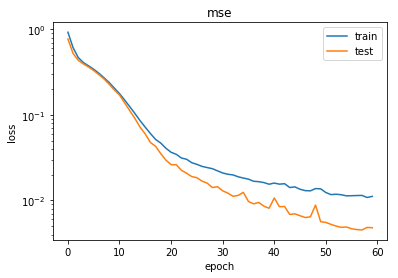

In [7]:
fig = plt.figure()
plt.semilogy(history.history['loss'])
if vsplit:
    plt.semilogy(history.history['val_loss'])
plt.title(loss_type)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Inference test

## prepare frontend for plotting

In [8]:
#@title import plotly
import plotly.plotly as py
import numpy as np
from plotly.offline import init_notebook_mode, iplot
# from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter
import plotly.graph_objs as go

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

## prepare data for plotting

## GPU data prepare

In [9]:
from sklearn.metrics import r2_score
# model.load_weights("./tmp/weights.best.cntk.hdf5")

x_test_df = pd.DataFrame(in_scaler.inverse_transform(x_test),columns=input_features)
y_test_df = pd.DataFrame(out_scaler.inverse_transform(y_test),columns=labels)

predict_val = model.predict(x_test,batch_size=1024*8)
predict_df = pd.DataFrame(out_scaler.inverse_transform(predict_val), columns=labels)

test_data=pd.concat([x_test_df,y_test_df],axis=1)
pred_data=pd.concat([x_test_df,predict_df],axis=1)

!rm sim_check.h5
test_data.to_hdf('sim_check.h5',key='test')
pred_data.to_hdf('sim_check.h5',key='pred')

df_test=pd.read_hdf('sim_check.h5',key='test')
df_pred=pd.read_hdf('sim_check.h5',key='pred')

zeta_level=list(set(df_test['zeta']))
zeta_level.sort()


res_sum=pd.DataFrame()
r2s=[]
r2s_i=[]

names=[]
maxs_0=[]
maxs_9=[]

for r2,name in zip(r2_score(df_test,df_pred,multioutput='raw_values'),df_test.columns):
  names.append(name)
  r2s.append(r2)
  maxs_0.append(df_test[df_test['zeta']==zeta_level[0]][name].max())
  maxs_9.append(df_test[df_test['zeta']==zeta_level[8]][name].max())
  for i in zeta_level:
    r2s_i.append(r2_score(df_pred[df_pred['zeta']==i][name],
                          df_test[df_test['zeta']==i][name]))

res_sum['name']=names
# res_sum['max_0']=maxs_0
# res_sum['max_9']=maxs_9
res_sum['z_scale']=[m_9/(m_0+1e-20) for m_9,m_0 in zip(maxs_9,maxs_0)]
# res_sum['r2']=r2s


tmp=np.asarray(r2s_i).reshape(-1,10)
for idx,z in enumerate(zeta_level):
  res_sum['r2s_'+str(z)]=tmp[:,idx]

res_sum[3:]

,name,z_scale,r2s_0.0,r2s_0.11,r2s_0.22,r2s_0.33,r2s_0.44,r2s_0.55,r2s_0.66,r2s_0.77,r2s_0.88,r2s_0.99
3,CH4,1.008505,0.994780,0.994296,0.997655,0.997332,0.995393,0.996314,0.996882,0.997552,0.995123,0.997170
4,O2,1.000000,0.997067,0.997426,0.998427,0.999059,0.998682,0.998793,0.998654,0.998528,0.997113,0.996920
5,H2O,0.222239,0.997854,0.997987,0.998709,0.999115,0.998769,0.997962,0.997918,0.995824,0.984976,0.619143
6,CO,0.181322,0.992870,0.994624,0.998615,0.998861,0.998070,0.997218,0.994052,0.995212,0.989503,0.634228
7,CO2,0.143767,0.969904,0.988498,0.991556,0.992254,0.994195,0.994616,0.990622,0.983852,0.973393,0.721595
8,T,0.295670,0.993699,0.997127,0.998110,0.998634,0.998385,0.997339,0.997252,0.997497,0.992943,0.712720
9,PVs,0.030422,0.991719,0.990635,0.985783,0.981829,0.978150,0.963704,0.916205,0.772695,0.651014,0.544869
10,psi,0.461212,0.995469,0.997687,0.997497,0.998063,0.998571,0.997975,0.997925,0.997864,0.994037,0.738866
11,mu,0.462740,0.995576,0.997829,0.997863,0.998253,0.998568,0.997902,0.997881,0.997902,0.993898,0.766881
12,alpha,1.000000,0.990705,0.995712,0.993640,0.993197,0.996410,0.995563,0.996469,0.996240,0.993568,0.975344


In [97]:
no_drop=res_sum[3:]
no_drop

,name,z_scale,r2s_0.0,r2s_0.11,r2s_0.22,r2s_0.33,r2s_0.44,r2s_0.55,r2s_0.66,r2s_0.77,r2s_0.88,r2s_0.99
3,CH4,1.013859,0.999470,0.999642,0.999756,0.999709,0.999490,0.999490,0.999484,0.999577,0.999289,0.999680
4,O2,1.000000,0.999480,0.999514,0.999665,0.999719,0.999709,0.999682,0.999719,0.999637,0.999428,0.999409
5,H2O,0.224147,0.999575,0.999639,0.999633,0.999607,0.999630,0.999525,0.999374,0.998955,0.997002,0.789479
6,CO,0.180405,0.998745,0.999184,0.999413,0.999371,0.999437,0.999325,0.999255,0.998964,0.992797,0.820672
7,CO2,0.133751,0.995674,0.998326,0.998865,0.998866,0.999107,0.999013,0.998769,0.998496,0.994330,0.801587
8,T,0.309810,0.999103,0.999222,0.999469,0.999479,0.999499,0.999538,0.999470,0.998841,0.996561,0.868342
9,PVs,0.029285,0.998542,0.997647,0.995841,0.993356,0.991055,0.990903,0.988154,0.984908,0.973439,0.458872
10,psi,0.473022,0.999023,0.999418,0.999517,0.999550,0.999519,0.999594,0.999510,0.999175,0.997891,0.928207
11,mu,0.475440,0.998992,0.999361,0.999579,0.999518,0.999542,0.999539,0.999497,0.999216,0.998086,0.938934
12,alpha,1.000000,0.996852,0.998195,0.998844,0.998948,0.998929,0.999365,0.999085,0.998701,0.998639,0.996719


## interactive plot

In [14]:
#@title Default title text
# species = np.random.choice(labels)
species = 'T' #@param {type:"string"}
z_level =  0 #@param {type:"integer"}

# configure_plotly_browser_state()
# init_notebook_mode(connected=False)

from sklearn.metrics import r2_score


df_t=df_test[df_test['zeta']==zeta_level[z_level]].sample(frac=1)
# df_p=df_pred.loc[df_pred['zeta']==zeta_level[1]].sample(frac=0.1)
df_p=df_pred.loc[df_t.index]
error=df_p[species]-df_t[species]
r2=round(r2_score(df_p[species],df_t[species]),4)

print(species,'r2:',r2,'max:',df_t[species].max())

fig_db = {
    'data': [       
        {'name':'test data from table',
         'x': df_t['f'],
         'y': df_t['pv'],
         'z': df_t[species],
         'type':'scatter3d', 
        'mode': 'markers',
          'marker':{
              'size':1
          }
        },
        {'name':'prediction from neural networks',
         'x': df_p['f'],
         'y': df_p['pv'],
         'z': df_p[species],
         'type':'scatter3d', 
        'mode': 'markers',
          'marker':{
              'size':1
          },
        },
        {'name':'error in difference',
         'x': df_p['f'],
         'y': df_p['pv'],
         'z': error,
         'type':'scatter3d', 
         'mode': 'markers',
          'marker':{
              'size':1
          },
         }       
    ],
    'layout': {
        'scene':{
            'xaxis': {'title':'mixture fraction'},
            'yaxis': {'title':'progress variable'},
            'zaxis': {'title': species+'_r2:'+str(r2)}
                 }
    }
}
# iplot(fig_db, filename='multiple-scatter')
iplot(fig_db)


T r2: 0.9717 max: 2151.56


In [56]:
model.save('trained_fgm_nn.h5')

In [99]:
model.save('trained_fgm_nn.h5')
%run -i k2tf.py --input_model='trained_fgm_nn.h5' --output_model='exported/fgm.pb'

DuplicateFlagError: The flag 'input_model' is defined twice. First from k2tf.py, Second from k2tf.py.  Description from first occurrence: Path to the input model.

<Figure size 432x288 with 0 Axes>

# Stutdent networ
The student network is trained on the synsetic data generated from the full teacher network. It is mean to simplify the final model used in production. 

In [60]:
from keras.models import Model
from keras.layers import Dense, Input
from keras.callbacks import ModelCheckpoint


n_neuron = 5
# %%
print('set up student network')
# ANN parameters
dim_input = x_train.shape[1]
dim_label = y_train.shape[1]

batch_norm = False

# This returns a tensor
inputs = Input(shape=(dim_input,),name='input_1')

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(n_neuron, activation='relu')(inputs)
x = Dense(n_neuron, activation='relu')(x)
x = Dropout(0.1)(x)
predictions = Dense(dim_label, activation='linear', name='output_1')(x)

student_model = Model(inputs=inputs, outputs=predictions)
student_model.summary()

set up student network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 20        
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 30        
_________________________________________________________________
dropout_3 (Dropout)          (None, 5)                 0         
_________________________________________________________________
output_1 (Dense)             (None, 2)                 12        
Total params: 62
Trainable params: 62
Non-trainable params: 0
_________________________________________________________________


In [61]:
batch_size = 1024*32
epochs = 60
vsplit = 0.1

loss_type='mse'

adam_op = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999,epsilon=1e-8, decay=0.0, amsgrad=True)

student_model.compile(loss=loss_type, optimizer=adam_op, metrics=[coeff_r2])
# model.compile(loss=cubic_loss, optimizer=adam_op, metrics=['accuracy'])

# checkpoint (save the best model based validate loss)
!mkdir ./tmp
filepath = "./tmp/student_weights.best.cntk.hdf5"

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             period=20)

# callbacks_list = [checkpoint]
callbacks_list = [lrate]

x_train_teacher = x_train
y_train_teacher = model.predict(x_train, batch_size=1024*8)
# fit the model
history = student_model.fit(
    x_train_teacher, y_train_teacher,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=vsplit,
    verbose=2,
#     callbacks=callbacks_list,
    shuffle=True)

mkdir: cannot create directory ‘./tmp’: File exists
Train on 1004379 samples, validate on 111598 samples
Epoch 1/60
 - 1s - loss: 1.3265 - coeff_r2: -3.3240e-01 - val_loss: 1.2014 - val_coeff_r2: -1.8974e-01
Epoch 2/60
 - 1s - loss: 1.1250 - coeff_r2: -1.2919e-01 - val_loss: 1.0639 - val_coeff_r2: -5.3356e-02
Epoch 3/60
 - 1s - loss: 1.0142 - coeff_r2: -1.7403e-02 - val_loss: 0.9817 - val_coeff_r2: 0.0282
Epoch 4/60
 - 1s - loss: 0.9434 - coeff_r2: 0.0532 - val_loss: 0.9215 - val_coeff_r2: 0.0879
Epoch 5/60
 - 1s - loss: 0.8881 - coeff_r2: 0.1091 - val_loss: 0.8697 - val_coeff_r2: 0.1393
Epoch 6/60
 - 1s - loss: 0.8405 - coeff_r2: 0.1568 - val_loss: 0.8239 - val_coeff_r2: 0.1847
Epoch 7/60
 - 1s - loss: 0.7986 - coeff_r2: 0.1989 - val_loss: 0.7825 - val_coeff_r2: 0.2258
Epoch 8/60
 - 1s - loss: 0.7610 - coeff_r2: 0.2368 - val_loss: 0.7433 - val_coeff_r2: 0.2646
Epoch 9/60
 - 1s - loss: 0.7257 - coeff_r2: 0.2721 - val_loss: 0.7076 - val_coeff_r2: 0.3000
Epoch 10/60
 - 1s - loss: 0.6958 

In [13]:
from sklearn.metrics import r2_score

x_test_df = pd.DataFrame(in_scaler.inverse_transform(x_test),columns=input_features)

predict_val = student_model.predict(x_test,batch_size=1024*8)
predict_df = pd.DataFrame(out_scaler.inverse_transform(predict_val), columns=labels)

pred_data=pd.concat([x_test_df,predict_df],axis=1)

!rm sim_check.h5
pred_data.to_hdf('sim_check.h5',key='pred')
df_pred=pd.read_hdf('sim_check.h5',key='pred')

zeta_level=list(set(df_test['zeta']))
zeta_level.sort()


res_sum=pd.DataFrame()
r2s=[]
r2s_i=[]

names=[]
maxs_0=[]
maxs_9=[]

for r2,name in zip(r2_score(df_test,df_pred,multioutput='raw_values'),df_test.columns):
  names.append(name)
  r2s.append(r2)
  maxs_0.append(df_test[df_test['zeta']==zeta_level[0]][name].max())
  maxs_9.append(df_test[df_test['zeta']==zeta_level[8]][name].max())
  for i in zeta_level:
    r2s_i.append(r2_score(df_pred[df_pred['zeta']==i][name],
                          df_test[df_test['zeta']==i][name]))

res_sum['name']=names
# res_sum['max_0']=maxs_0
# res_sum['max_9']=maxs_9
res_sum['z_scale']=[m_9/(m_0+1e-20) for m_9,m_0 in zip(maxs_9,maxs_0)]
# res_sum['r2']=r2s


tmp=np.asarray(r2s_i).reshape(-1,10)
for idx,z in enumerate(zeta_level):
  res_sum['r2s_'+str(z)]=tmp[:,idx]

res_sum[3:]

,name,z_scale,r2s_0.0,r2s_0.11,r2s_0.22,r2s_0.33,r2s_0.44,r2s_0.55,r2s_0.66,r2s_0.77,r2s_0.88,r2s_0.99
3,CH4,1.008505,0.971500,0.987782,0.993755,0.992194,0.988337,0.990516,0.992561,0.995902,0.991570,0.995409
4,O2,1.000000,0.987625,0.991136,0.993322,0.995098,0.996573,0.998220,0.998468,0.997902,0.994167,0.988721
5,H2O,0.222239,0.983944,0.993169,0.993735,0.995091,0.996454,0.996701,0.996895,0.988193,0.943449,0.446626
6,CO,0.181322,0.952372,0.969151,0.984470,0.990651,0.994517,0.992602,0.991570,0.984378,0.939984,0.384443
7,CO2,0.143767,0.857708,0.911901,0.963990,0.963058,0.967662,0.966969,0.952636,0.938890,0.944349,0.577656
8,T,0.295670,0.971685,0.988545,0.993414,0.993663,0.994816,0.995572,0.995843,0.992465,0.969658,0.493271
9,PVs,0.030422,-1.259126,0.552150,0.756739,0.702127,0.595810,0.500029,0.427537,0.359685,-0.169924,-0.275544
10,psi,0.461212,0.964584,0.983095,0.991711,0.991252,0.992692,0.992830,0.994645,0.991764,0.973992,0.560999
11,mu,0.462740,0.972904,0.986585,0.993010,0.994129,0.995148,0.995341,0.995629,0.992655,0.974620,0.550289
12,alpha,1.000000,0.948433,0.965166,0.976732,0.973191,0.980955,0.986462,0.988344,0.984737,0.974464,0.941372


## save student network weights

In [71]:
import h5py
!rm student_model_weights.h5
student_model.save('student_model_weights.h5')
f = h5py.File('student_model_weights.h5','r')
dset=f['model_weights']
list(dset)

['dense_5', 'dense_6', 'dropout_3', 'input_1', 'output_1']

In [92]:
l1_w=dset['dense_5']['dense_5']['kernel:0'][:]
l1_b=dset['dense_5']['dense_5']['bias:0'][:]
l1_c=np.vstack([l1_w,l1_b])
l1_c=pd.Series(list(l1_c)).to_json()

l2_w=dset['dense_6']['dense_6']['kernel:0'][:]
l2_b=dset['dense_6']['dense_6']['bias:0'][:]
l2_c=np.vstack([l2_w,l2_b])
l2_c=pd.Series(list(l2_c)).to_json()

l3_w=dset['output_1']['output_1_2']['kernel:0'][:]
l3_b=dset['output_1']['output_1_2']['bias:0'][:]
l3_c=np.vstack([l3_w,l3_b])
l3_c=pd.Series(list(l3_c)).to_json()



In [94]:
!rm data.json
print("{",file=open('data.json','w'))
print('"l1":',l1_c,file=open('data.json','a'))
print(',"l2":',l2_c,file=open('data.json','a'))
print(',"output":',l3_c,file=open('data.json','a'))
print("}",file=open('data.json','a'))

In [97]:
test_id=200
print(x_test[test_id])
print(student_model.predict(x_test[test_id].reshape(-1,3)))
print(y_test[test_id])

[0.3   0.948 0.33 ]
[[1.6095568 0.8250705]]
[ 1.7677916  -0.10766362]


In [90]:
l1_b

array([ 0.2093982 , -0.05028194,  0.44980595,  0.1120008 , -0.17164879],
      dtype=float32)

In [89]:
np.vstack([l1,l1_b])

array([[-1.505183  , -0.48669735, -1.0311114 , -0.83720607, -2.1831415 ],
       [-0.49262458,  0.5467909 ,  0.41370386,  0.7635428 ,  0.3367838 ],
       [ 1.2676779 ,  0.44149137, -0.19589986,  0.00307888,  0.67396855],
       [ 0.2093982 , -0.05028194,  0.44980595,  0.1120008 , -0.17164879]],
      dtype=float32)

In [107]:
student_model.predict(np.asarray([0.5,0.1,0.1]).reshape(-1,3))

array([[-0.47643796, -0.39353642]], dtype=float32)

In [106]:
student_model.save_weights('student_weights.h5')